# Train a viseme classifier

> Train a viseme classifier in colab.

# TODO
- overview of pre-requisits

combine 0:no expression and 4:random into a single 0:ignore class

at inference time, we don't care about the difference

the class imbalance might also be useful - as this will be our do nothing default - and we only want to take action when we're sure a command is being requested

TODO: 
- save stats with model
- Try bigger batch size - even if it means we need more epochs
- model size/depth
- Exaggerate 0 imbalance - how far do we have to go to not got any 0s misclassified (on test set)
- see what happens if we don't use nose landmarks for training - try with/without normalizing for nose

In [1]:
# run this, then restart the runtime
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 186 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 3.4 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from fastai.tabular.all import *
from pathlib import Path
import pandas as pd

In [3]:
path = Path('/content/drive/MyDrive/Colab Notebooks/datasets/expoco/processed_20211019_205023')
df = pd.read_csv(path/'data.csv')

In [40]:
df

In [20]:
dls = TabularDataLoaders.from_df(df, path, procs=[], cat_names=[], cont_names=list(df.columns[:-1]), 
                                 y_names=df.columns[-1], y_block=CategoryBlock,
                                 valid_idx=list(range(0, len(df), 10)), bs=256)
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=0.0010000000474974513)

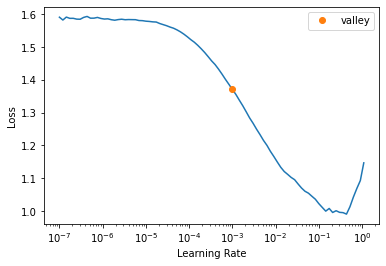

In [21]:
learn.lr_find()

# relative to tip of nose
```
bs 64
25, 8e-4 -> 97.4 + wd=1e-2 -> 97.7
bs 256
25, 8e-4, wd=1e-2 -> 98.1-98.4
bs 1024
35, 8e-4, wd=1e-2 -> 97.7
```
# relative to top lip indent

slighly lower accuracy but might give us better results if we care about not misclassifying no expression

```
bs 256
25, 8e-4, wd=1e-2 -> 97.3
25, 8e-4, wd=8e-3 -> 97.8

```

In [22]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(25, 1e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.172282,1.157243,0.629000,00:00
1,0.861692,0.593039,0.842000,00:00
2,0.589007,0.302679,0.921000,00:00
3,0.418708,0.253927,0.927000,00:00
4,0.324092,0.271895,0.914000,00:00
5,0.283919,0.211981,0.935000,00:00
6,0.237276,0.200604,0.930000,00:00
7,0.219431,0.224933,0.917000,00:00
8,0.203768,0.160325,0.946000,00:00
9,0.177669,0.174450,0.937000,00:00


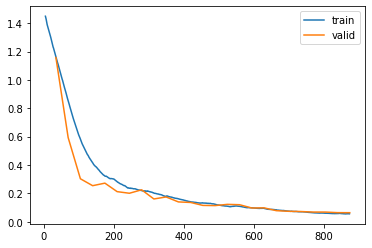

In [23]:
learn.recorder.plot_loss()

In [60]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(212, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=212, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=4, bias=True)
    )
  )
)

In [24]:
import pickle
class NpModelHelper:
    def __init__(self, path, model_id):
        self.model_id, self.path = model_id, path/f'model_{model_id}.pkl'
    def set_state(self, model):
        self.state_dict, state_dict = {}, learn.model.state_dict()
        for k in state_dict:
            self.state_dict[k] = state_dict[k].detach().cpu().numpy()
        return self
    def save(self):
        # can't set allow_pickle=False with np.savez https://github.com/numpy/numpy/issues/13983
        # so we might as well pickle and keep the dict order
        # TODO: don't need the dict order any more - go back to npz
        with open(self.path, 'wb') as f:
            pickle.dump(self.state_dict, f)
        return self
    def load(self):
        with open(self.path, 'rb') as f:
            self.state_dict = pickle.load(f)
        return self
    def get_state_dict(self, name_prefix):
        if name_prefix is None or name_prefix == '': 
            return self.state_dict
        return {k[len(name_prefix)+1:]:self.state_dict[k] 
                for k in self.state_dict 
                if k.startswith(name_prefix)}

In [25]:
np_model_helper = NpModelHelper(path, dataset_id)
np_model_helper.set_state(learn.model).save()

In [26]:
np_model_helper = NpModelHelper(path, dataset_id).load()

In [27]:
class NpBatchNorm1d:
    # https://github.com/pytorch/pytorch/blob/420b37f3c67950ed93cd8aa7a12e673fcfc5567b/aten/src/ATen/native/Normalization.cpp#L61-L126
    def __init__(self, weight, bias, running_mean, running_var, num_batches_tracked=None):
        self.weight, self.bias = weight, bias
        self.running_mean, self.running_std = running_mean, np.sqrt(running_var + 1e-5)
    def __call__(self, x):
        x = x - self.running_mean
        x = x / self.running_std
        x = x * self.weight
        x = x + self.bias
        return x

In [28]:
class NpLinear:
    def __init__(self, weight, bias=None):
        self.weight, self.bias = weight.T, bias
    def __call__(self, x):
        x = x @ self.weight
        if self.bias is not None:
            x = x + self.bias
        return x

In [29]:
class NpReLU:
    def __call__(self, x):
        return np.maximum(x, 0)

In [30]:
class NpModel:
    def __init__(self, modules):
        self.modules = modules
    def __call__(self, x):
        for module in self.modules:
            x = module(x)
        return x

In [31]:
np_model = NpModel([
                    NpBatchNorm1d(**np_model_helper.get_state_dict('bn_cont')),
                    NpLinear(**np_model_helper.get_state_dict('layers.0.0')),
                    NpReLU(),
                    NpBatchNorm1d(**np_model_helper.get_state_dict('layers.0.2')),
                    NpLinear(**np_model_helper.get_state_dict('layers.1.0')),
                    NpReLU(),
                    NpBatchNorm1d(**np_model_helper.get_state_dict('layers.1.2')),
                    NpLinear(**np_model_helper.get_state_dict('layers.2.0'))
                   ])

In [32]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(212, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=212, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=4, bias=True)
    )
  )
)

In [33]:
class_id_to_label = {
        0: "No expression",
        1: "oo",
        2: "ee",
        3: "ah",
        4: "Random Talking"
    }

In [34]:
confusion_matrix = np.zeros([5,5], dtype=int) # TODO: don't hard code
output = np_model(df[cont_names].to_numpy())
preds = np.argmax(output, axis=1)
targets = df['expression_id'].to_numpy()
for p,t in zip(preds, targets):
    confusion_matrix[t][p]+=1

In [72]:
confusion_matrix

array([[3950,    9,   17,   24,    0],
       [   9, 1991,    0,    0,    0],
       [  19,    0, 1942,   39,    0],
       [   1,    0,   33, 1966,    0],
       [   0,    0,    0,    0,    0]])

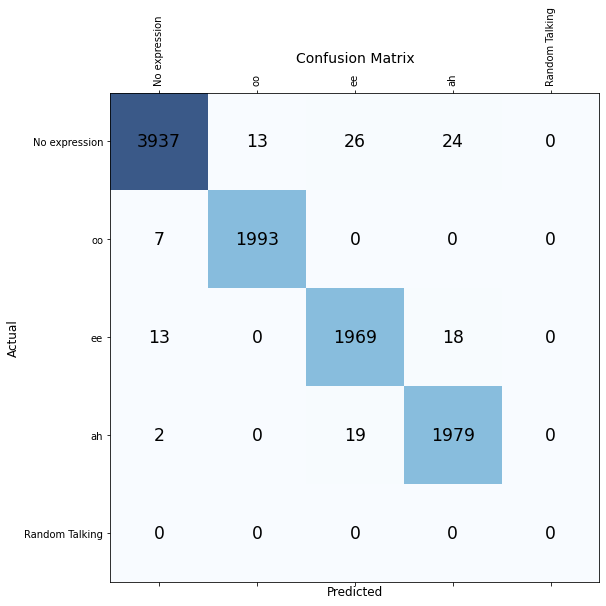

In [35]:
# confusion_matrix = np.array([[0,2,1],[1,2,0],[2,1,0]])
fig, ax = plt.subplots(figsize=(9,9))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.8)
# ax.xaxis.set_ticks_position('bottom') # must be after matshow
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
tick_marks = np.arange(5)
# plt.xticks(tick_marks, self.data.y.classes, rotation=90)
plt.xticks(tick_marks, class_id_to_label.values(), rotation=90)
plt.yticks(tick_marks, class_id_to_label.values(), rotation=0)
plt.show()

In [38]:
df

,img_path,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,3y,3z,4x,4y,4z,5x,5y,5z,6x,6y,6z,7x,7y,7z,8x,8y,8z,9x,9y,9z,10x,10y,10z,11x,11y,11z,12x,12y,12z,...,455x,455y,455z,456x,456y,456z,457x,457y,457z,458x,458y,458z,459x,459y,459z,460x,460y,460z,461x,461y,461z,462x,462y,462z,463x,463y,463z,464x,464y,464z,465x,465y,465z,466x,466y,466z,467x,467y,467z,expression_id
0,NaN,0.0,0.0,-0.030659,-0.265645,1.136175,0.818417,-0.290295,1.111212,1.360473,-0.269436,1.238497,-0.207675,-0.261574,1.168478,0.520406,-0.267542,1.210344,0.131738,-0.291722,1.323504,-0.671683,-0.312267,1.262642,-0.435192,-0.299998,1.429369,-0.834608,-0.294927,1.463271,-0.875733,-0.306962,1.506396,-0.934491,-0.296655,1.004835,1.215771,-0.302754,0.972410,1.197331,...,-0.344967,1.177815,0.664157,-0.305088,1.248109,-0.086188,-0.292290,1.152598,0.712624,-0.293461,1.131325,0.993972,-0.300311,1.149251,0.763651,-0.347922,1.162713,0.784169,-0.286520,1.127701,1.022474,-0.295567,1.120671,1.232791,-0.362380,1.405506,-0.671794,-0.353188,1.382140,-0.710961,-0.338650,1.358950,-0.700030,-0.397506,1.305635,-0.363628,-0.421346,1.393531,-0.370220,0
1,NaN,0.0,0.0,-0.031247,-0.264344,1.216585,0.762081,-0.287766,1.194034,1.196429,-0.275821,1.292921,-0.133480,-0.262291,1.240248,0.499305,-0.270993,1.270447,0.151336,-0.302384,1.351755,-0.565898,-0.312332,1.391507,-0.321491,-0.319470,1.426551,-0.708801,-0.319688,1.446419,-0.735779,-0.341406,1.548995,-0.796208,-0.292759,1.089932,1.121418,-0.296635,1.062578,1.103115,...,-0.324440,1.240428,0.540109,-0.307217,1.295287,-0.087921,-0.284015,1.229284,0.622224,-0.284813,1.212508,0.874495,-0.290878,1.226434,0.664162,-0.326565,1.227217,0.647211,-0.279689,1.210352,0.907856,-0.286486,1.203992,1.072886,-0.373977,1.429217,-0.619358,-0.363876,1.406895,-0.636792,-0.349120,1.385197,-0.621072,-0.421442,1.359321,-0.373347,-0.445453,1.411725,-0.377226,0
2,NaN,0.0,0.0,-0.030301,-0.264779,1.618143,0.920779,-0.294080,1.598186,1.266994,-0.283003,1.736222,-0.140467,-0.261357,1.645517,0.641182,-0.271986,1.691073,0.217753,-0.309038,1.850794,-0.630747,-0.346649,2.057971,-0.395414,-0.329960,1.890991,-0.789223,-0.328735,1.894402,-0.805423,-0.336415,2.165434,-0.902936,-0.301195,1.391814,1.306674,-0.306751,1.366508,1.291867,...,-0.309796,1.659558,0.562166,-0.306845,1.749830,-0.115415,-0.276133,1.649160,0.734118,-0.279490,1.635276,1.009259,-0.282677,1.653885,0.757541,-0.314218,1.640612,0.663641,-0.275862,1.626993,1.051509,-0.283881,1.623960,1.177694,-0.382380,2.034012,-0.778709,-0.370351,1.979697,-0.799373,-0.354515,1.933560,-0.742459,-0.446883,2.203644,-0.482231,-0.461616,2.123237,-0.458738,0
3,NaN,0.0,0.0,-0.025137,-0.215211,2.632253,1.100361,-0.259513,2.601452,2.073586,-0.210346,2.729927,-0.768568,-0.202766,2.664805,0.572257,-0.203781,2.707873,-0.156556,-0.223360,2.810812,-1.473329,-0.271728,2.770148,-0.958704,-0.223744,2.806168,-1.674443,-0.212633,2.804141,-1.677676,-0.184430,2.966138,-1.801271,-0.286374,2.326582,2.243319,-0.296287,2.298287,2.224900,...,-0.270110,2.652712,1.013409,-0.243248,2.754137,-0.462122,-0.223919,2.668701,0.961676,-0.230732,2.649289,1.424692,-0.232729,2.668353,1.053518,-0.274750,2.633158,1.224752,-0.228406,2.641672,1.452716,-0.238822,2.636670,1.819156,-0.307178,2.904605,-1.351401,-0.294373,2.876422,-1.460098,-0.276297,2.857246,-1.445128,-0.359813,3.097829,-0.718363,-0.380026,3.007512,-0.688371,0
4,NaN,0.0,0.0,-0.023318,-0.158780,2.649266,1.199735,-0.201950,2.603593,2.350142,-0.167380,2.745715,-0.869264,-0.150586,2.688152,0.607031,-0.158049,2.731306,-0.181300,-0.192401,2.803756,-1.665009,-0.232962,2.709195,-1.076124,-0.205434,2.808129,-1.878689,-0.200408,2.815203,-1.881184,-0.201140,2.908742,-2.017134,-0.222098,2.387520,2.557570,-0.230930,2.352431,2.504959,...,-0.222854,2.614576,1.100859,-0.201332,2.746945,-0.558337,-0.171546,2.665012,1.031983,-0.174731,2.643152,1.562302,-0.178407,2.654800,1.141624,-0.226555,2.596680,1.362255,-0.172077,2.640781,1.598741,-0.182331,2.627799,2.026856,-0.291343,2.810146,-1.527558,-0.273318,2.805383,-1.645958,-0.251106,2.802577,-1.639525